# OSM Nodes Located in Pavement Polygons - London

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import os

import requests
import json

from matplotlib import pyplot as plt

C:\Anaconda3\envs\geoforge\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Anaconda3\envs\geoforge\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=T

## Functions

In [2]:
def osm_gdf_from_query(query, url = "http://overpass-api.de/api/interpreter", csr = {'init':'epsg:4326'}):
    response = requests.get(url, params={'data': query})

    status = response.raise_for_status()
    if status is not None:
        print(status)
        return

    data = response.json()

    if len(data['elements'])>0:
        df = pd.DataFrame(data['elements'])

        # drop entries with null lat lon
        df = df.loc[ (df.lon.notnull()) & (df.lat.notnull()) ]
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat))
    else:
        gdf = gpd.GeoDataFrame()

    gdf.crs = osm_crs

    return gdf

def aggregate_tag_data(tags):
    tag_data = {}
    for tag in tags:
        for key in tag.keys():
            if key not in tag_data.keys():
                tag_data[key] = {}

            value = tag[key]
            value = value.strip().replace(" ", "_").lower()

            if value not in tag_data[key].keys():
                tag_data[key][value] = 1
            else:
                tag_data[key][value] += 1
    return tag_data

def tag_bar_chart(series, series_label, ylabel, img_path):
    f, ax = plt.subplots(figsize = (10,10))

    p1 = ax.bar(series.index, series, 0.9, label=series_label)

    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(series.index)))
    ax.set_xticklabels(series.index)
    ax.legend()
    plt.xticks(rotation=30, ha='right')
    f.savefig(img_path)
    return f, ax

## Load pavement and carriadgeway polygons

In [3]:
osm_crs = {'init':'epsg:4326'}
projectCRS = {'init' :'epsg:27700'}

topographic_data_dir = "..\\data\\london\\clapham_common\\"

overpass_url = "http://overpass-api.de/api/interpreter"

pedestrian_polygon_file = os.path.join(topographic_data_dir, "topographicAreaPedestrian.shp")
vehicle_polygon_file = os.path.join(topographic_data_dir, "topographicAreaVehicle.shp")

gdfPedTopo = gpd.read_file(pedestrian_polygon_file)
gdfVehTopo = gpd.read_file(vehicle_polygon_file)

gdfPedTopo = gdfPedTopo.reindex(columns = ['fid', 'descript_1', 'geometry'])
gdfVehTopo = gdfVehTopo.reindex(columns = ['fid', 'descript_1', 'geometry'])

gdfPedTopo.crs = projectCRS
gdfPedTopo = gdfPedTopo.to_crs(osm_crs)
gdfVehTopo.crs = projectCRS
gdfVehTopo = gdfVehTopo.to_crs(osm_crs)

In [4]:
# Set study area bounding box
e,s,w,n = gdfPedTopo.total_bounds
bb_string = "{},{},{},{}".format(s,e,n,w)

## Query and analyse OSM data

In [5]:
# OSM query
all_bb_metadata = """
[out:json] [bbox:{}];
(
  node;
  <;
);
out meta;
""".format(bb_string)

C:\Anaconda3\envs\geoforge\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


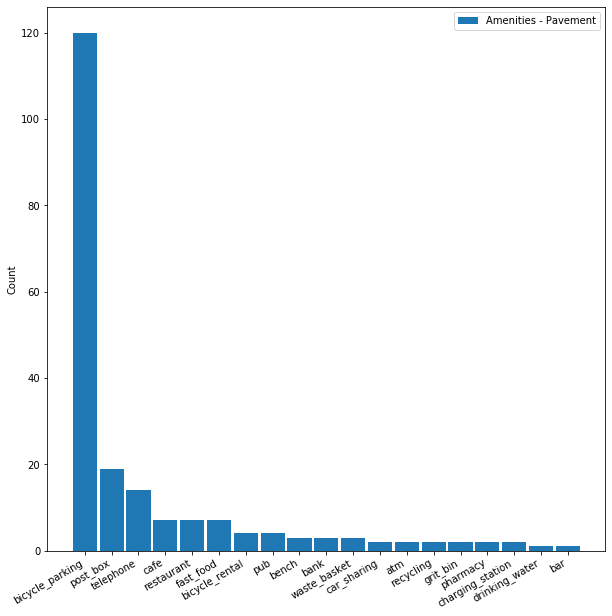

In [7]:
gdf = osm_gdf_from_query(all_bb_metadata)
assert gdf.geometry.is_valid.all()

# Spatial join gdf to pedestrian topographic polygons to filter out itmes that are on pavement
gdfPed = gpd.sjoin(gdf, gdfPedTopo, how = 'inner')

# Descriptive statistics of tags
tags = gdfPed.loc[ ~gdfPed['tags'].isnull(), 'tags'].values
ped_tag_data = aggregate_tag_data(tags)
dfPedAmenities = pd.DataFrame(index = ped_tag_data['amenity'].keys(), data=ped_tag_data['amenity'].values(), columns=['count'])
dfPedAmenities.sort_values(by = 'count', ascending=False, inplace=True)

# Now plot
f, ax = tag_bar_chart(dfPedAmenities['count'], "Amenities - Pavement", "Count", "..\\images\\clapham_amenities_ped.png")
f.show()

C:\Anaconda3\envs\geoforge\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


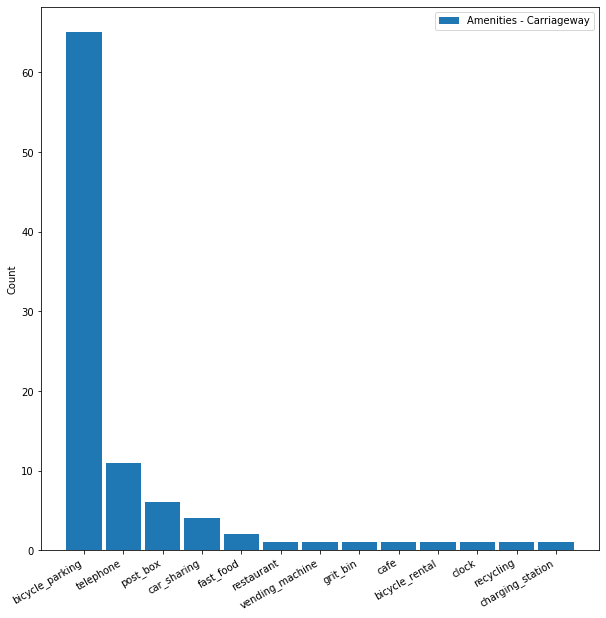

In [8]:
gdfVeh = gpd.sjoin(gdf, gdfVehTopo, how = 'inner')
tags = gdfVeh.loc[ ~gdfVeh['tags'].isnull(), 'tags'].values
veh_tag_data = aggregate_tag_data(tags)
dfVehAmenities = pd.DataFrame(index = veh_tag_data['amenity'].keys(), data=veh_tag_data['amenity'].values(), columns=['count'])
dfVehAmenities.sort_values(by = 'count', ascending=False, inplace=True)

f, ax = tag_bar_chart(dfVehAmenities['count'], "Amenities - Carriageway", "Count", "..\\images\\clapham_amenities_veh.png")
f.show()

In [9]:
# Tags other than 'amenity'
print("Pavement space tags")
list(ped_tag_data.keys())

Pavement space tags


['addr:housenumber',
 'addr:postcode',
 'addr:street',
 'amenity',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'cuisine',
 'fhrs:authority',
 'fhrs:id',
 'fhrs:inspectiondate',
 'fhrs:rating',
 'name',
 'outdoor_seating',
 'takeaway',
 'level',
 'official_name',
 'healthcare',
 'atm',
 'shop',
 'barrier',
 'bicycle',
 'bench',
 'bus',
 'highway',
 'local_ref',
 'naptan:AtcoCode',
 'naptan:Bearing',
 'naptan:CommonName',
 'naptan:Indicator',
 'naptan:Street',
 'naptan:verified',
 'public_transport',
 'shelter',
 'post_box:type',
 'traffic_calming',
 'traffic_signals:direction',
 'natural',
 'direction',
 'bicycle_parking',
 'capacity',
 'covered',
 'source',
 'railway',
 'wheelchair',
 'artwork_type',
 'tourism',
 'addr:city',
 'addr:housename',
 'building',
 'internet_access',
 'note',
 'foot',
 'continuous',
 'sidewalk',
 'crossing',
 'crossing_ref',
 'fare_zone',
 'line',
 'name:ru',
 'network',
 'station',
 'subway',
 'wikidata',
 'wikipedia',
 'created_by',
 'swing_gate:type'

In [10]:
print("Carriadgeway space tags")
list(veh_tag_data.keys())

Carriadgeway space tags


['amenity',
 'capacity',
 'operator',
 'source',
 'booth',
 'covered',
 'bus',
 'highway',
 'local_ref',
 'name',
 'naptan:AtcoCode',
 'naptan:Bearing',
 'naptan:CommonName',
 'naptan:Indicator',
 'naptan:Street',
 'naptan:verified',
 'public_transport',
 'natural',
 'traffic_signals:direction',
 'traffic_calming',
 'barrier',
 'bicycle_parking',
 'on_carriageway',
 'tfl_id',
 'continuous',
 'sidewalk',
 'cycleway',
 'direction',
 'created_by',
 'rcn',
 'rcn_name',
 'crossing',
 'crossing:island',
 'crossing_ref',
 'traffic_signals',
 'addr:housenumber',
 'addr:street',
 'cuisine',
 'alt_name',
 'vending',
 'access',
 'emergency',
 'motor_vehicle',
 'website',
 'bench',
 'shelter',
 'tactile_paving',
 'Continious',
 'surface',
 'supervised',
 'shop',
 'colour',
 'material',
 'button_operated',
 'traffic_signals:sound',
 'traffic_signals:vibration',
 'brand',
 'brand:wikidata',
 'brand:wikipedia',
 'local',
 'network',
 'official_name',
 'official_ref',
 'bicycle',
 'demolished:highway'